# Create and pair agents
Create noised version of the reference matrix and pair up individual agents.

In [35]:
import glob
from animal_game.utils import compute_thresholds
from animal_game.agents import Agent
import itertools
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import random
from multiprocessing import Pool

In [36]:
models = ['animal_game/models/wiki_euclidean_distance.tsv']
animals = pd.read_csv('animal_game/models/animal_list.csv')
thresholds = compute_thresholds(models, 
                                q=[round(n,2) for n in np.arange(0.05, 1.0, 0.05)], 
                                round_at=5)

### Generate noised matrices

Read in the vectors

In [37]:
X_vec = pd.read_csv('animal_game/models/wiki_vectors.tsv', 
                           sep='\t', index_col=0, header=None)
X_vec_scaled = MinMaxScaler().fit_transform(X_vec)
X = pd.read_csv('animal_game/models/wiki_euclidean_distance.tsv', 
                sep='\t', index_col=0) # changed

In [38]:
X.values[np.tril_indices(X.values.shape[0], -1)] = np.nan
for i in range(X.shape[0]):
    X.values[i,i]=np.nan
long = pd.melt(X.reset_index(), id_vars='index').dropna()
long.columns = ['a1', 'a2', 'distance']
long['distance_bins'] = pd.cut(long.distance, 5, labels=range(5)).astype(float)

In [39]:
long.groupby('distance_bins').a1.count()

distance_bins
0.0       68
1.0     1254
2.0    11227
3.0    15420
4.0      711
Name: a1, dtype: int64

0.011801407633947275


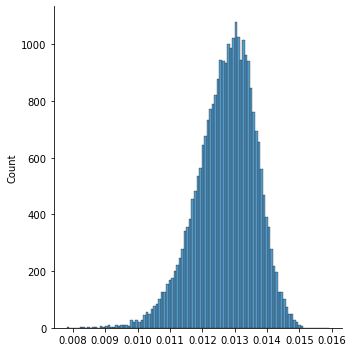

In [40]:
sns.displot(X.values.ravel())
print(np.nanquantile(X.values.ravel(), .15))

In [43]:
date = '21_06_11'
nr_agents_per_nl = 500
noise_levels = range(2)#range(5)
probabilities = [.2]

In [ ]:
all_sampled = {}
for nl in noise_levels:
    all_sampled[nl] = []
    for p in probabilities:
        for _ in range(nr_agents_per_nl):
            sample_from = long[long['distance_bins'].astype(float) <= nl]
            sampled = list(sample_from.sample(frac=p)[['a1', 
                                                       'a2']].to_records(index=False))
            all_sampled[nl].append(sampled)

In [ ]:
adict = dict(zip(animals['Animals'].tolist(),
                 list(range(len(animals)))))

In [101]:
eudist_mats = []
mats = []
for nl in all_sampled.keys():
    print(nl)
    for idx, agent in enumerate(all_sampled[nl][:10]):
        agent_shuffle = agent.copy()
        random.shuffle(agent_shuffle)
        for a1, a2 in agent_shuffle:
            X_agent = X_vec_scaled.copy()
            X_agent[[adict[a1], adict[a2]]] = X_agent[[adict[a2], 
                                                       adict[a1]]]
#        df_agent = pd.DataFrame(X_agent)
#        df_agent.index = animals['Animals'].tolist()
#        fname = f'wiki_{nl}_{idx}.tsv'
#        df_agent.to_csv(f'animal_game/models/{date}/noised_vectors/{fname}', 
#                        sep='\t')
#        mats.append((idx, nl, X_agent))
#        # Save distances
#        ed_agent = euclidean_distances(X_agent, X_agent) / 400
#        e_df_agent = pd.DataFrame(ed_agent)
#        e_df_agent.index = df_agent.index
#        e_df_agent.columns = e_df_agent.index
#        e_df_agent.to_csv(f'animal_game/models/{date}/noised_distance_matrices/{fname}',
#                   sep='\t')
#        eudist_mats.append((idx, nl, ed_agent))

0
1


False

In [83]:
noise_levels = [0.01, 0.02, 0.03, 0.04]
eudist_mats = [] # distance matrices
mats = [] # vectors matrics
for idx in range(nr_agents_per_nl):
    for nl in noise_levels:
        #noise = np.random.uniform(low=-nl, high=nl, size=X.values.shape)
        noise = np.random.normal(loc=0.0, scale=nl/3, size=X_vec_scaled.shape)
        X_noised = noise + X_vec_scaled
        X_noised = np.vectorize(lambda x: 0 if x < 0 else x)(X_noised)
        X_noised = np.vectorize(lambda x: 1 if x > 1 else x)(X_noised)
        # Save matrix
        df = pd.DataFrame(X_noised)
        df.index = animals['Animals'].tolist()
        fname = f'wiki_{nl}_{idx}.tsv'
#        df.to_csv(f'animal_game/models/{date}/noised_vectors/{fname}', 
#                  sep='\t')
        mats.append((idx, nl, X_noised))
        # Save distances
        ed = euclidean_distances(X_noised, X_noised) / 400
        edf = pd.DataFrame(ed)
        edf.index = df.index
        edf.columns = edf.index
#        edf.to_csv(f'animal_game/models/{date}/noised_distance_matrices/{fname}',
#                   sep='\t')
        eudist_mats.append((idx, nl, ed))

In [99]:
import os
len(os.listdir(f'animal_game/logs/21_06_11/pairs'))

1000

## Compute all pairwise distances between agents

In [ ]:
### Could actually sample random pairs

In [24]:
def _compute_distance(c):
    distance = np.mean(np.sqrt(np.sum(np.square(c[0][2] - c[1][2]), axis=1)))
    noise_level1 = c[0][1]
    noise_level2 = c[1][1]
    idx1 = c[0][0]
    idx2 = c[1][0]
    return (idx1, idx2,
            noise_level1, noise_level2,
            distance)

In [25]:
resdict = {}
for nl in noise_levels:
    vcombs = list(itertools.combinations([m for m in mats if m[1] == nl], 2))
    pool = Pool(processes=20)
    results = pool.map(_compute_distance, vcombs)
    resdict[nl] = results
    pool.close()

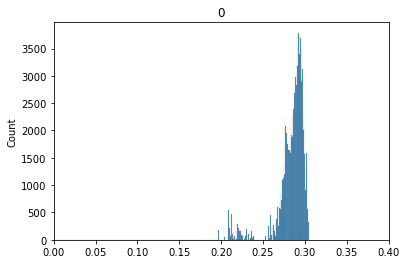

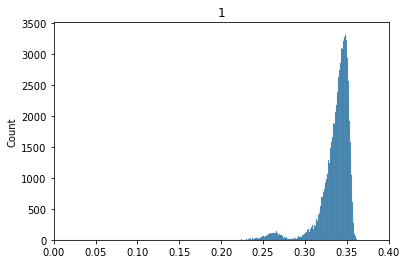

In [28]:
for k in resdict.keys():
    sns.histplot(x=[r[-1] for r in resdict[k]])
    plt.xlim(0,0.4)
    plt.title(k)
    plt.show()

In [76]:
# Run simulation
for idx, nl in enumerate(noise_levels):
    sampled = distance_df[distance_df['noise_level1'] == nl].sample(n=500)
    if idx == 0:
        sampled_all = sampled
    else:
        sampled_all = pd.concat([sampled_all, sampled], ignore_index=False)

In [77]:
sampled_all.drop(['perf1', 'perf2', 
                  'perf_diff'], axis=1).to_csv('animal_game/models/21_06_11/sampled_pairs.tsv',
                                               sep='\t')

## Plot performance vs. distance and sample

In [56]:
for idx, r in enumerate(resdict.keys()):
    ddf = pd.DataFrame(resdict[r], columns=['idx1', 'idx2', 
                                            'noise_level1', 'noise_level2',
                                            'distance'])
    if idx == 0:
        distance_df = ddf
    else:
        distance_df = pd.concat([ddf, distance_df], ignore_index=True)
    

In [57]:
distance_df['fname_1'] = 'wiki_' + distance_df['noise_level1'].astype(str) + '_' + distance_df['idx1'].astype(str) + '.tsv'
distance_df['fname_2'] = 'wiki_' + distance_df['noise_level2'].astype(str) + '_' + distance_df['idx2'].astype(str) + '.tsv'

In [58]:
fnames1 = distance_df.fname_1.unique().tolist()
fnames2 = distance_df.fname_2.unique().tolist()
individuals = list(set(fnames1 + fnames2))
dct = {}
for i in individuals:
    ind = i.strip('.tsv')+ '_1_0.01179.txt'
    avg_perf = pd.read_csv(f'animal_game/logs/{date}/individual/{ind}').groupby('iter').turn.max().mean()
    dct[i] = avg_perf

In [59]:
distance_df['perf1'] = distance_df['fname_1'].map(dct)
distance_df['perf2'] = distance_df['fname_2'].map(dct)
distance_df['perf_diff'] = distance_df['perf1'] - distance_df['perf2']

In [60]:
distance_df = distance_df[distance_df['noise_level1'] == distance_df['noise_level2']]

/home/roberta/venvs/dl_test/lib/python3.8/site-packages/seaborn/distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


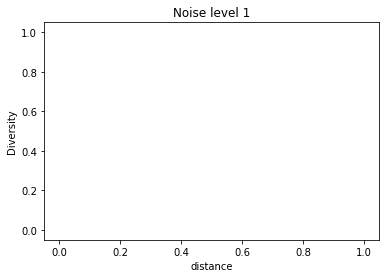

/home/roberta/venvs/dl_test/lib/python3.8/site-packages/seaborn/distributions.py:1078: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


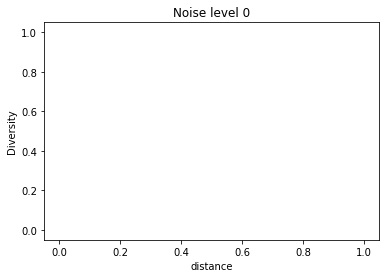

In [61]:
for nl in distance_df['noise_level1'].unique():
    sns.kdeplot(data=distance_df[distance_df['noise_level1']==nl], 
                x='distance', y='perf_diff',
                fill=True, thresh=0, levels=100, cmap="mako")
    plt.title(f'Noise level {nl}')
    plt.ylabel('Diversity')
    plt.show()

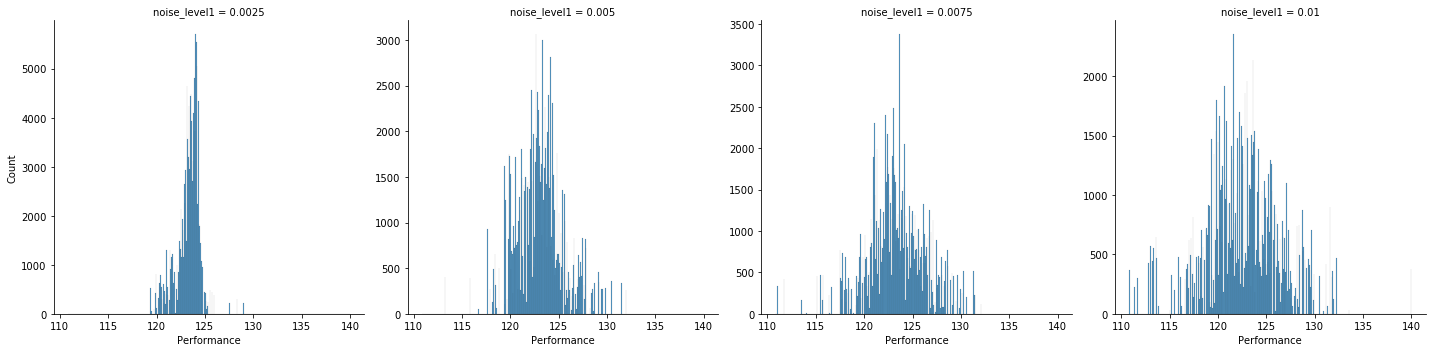

In [136]:
f = sns.displot(data=distance_df, 
                x='perf1', 
                col='noise_level1',
                legend=False,
                facet_kws={'sharex': False, 
                           'sharey': False})
for a in f.axes:
    for ax in a:
        ax.set_xlabel('Performance')
plt.show()

In [140]:
np.corrcoef(distance_df['perf_diff'], 
            distance_df['distance'])

array([[ 1.00000000e+00, -1.71941082e-04],
       [-1.71941082e-04,  1.00000000e+00]])

## Sample 500 pairs with "even" distancing

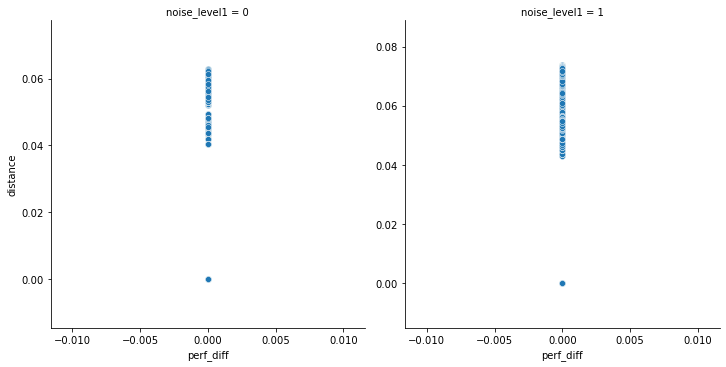

In [67]:
sns.relplot(data=distance_df, 
            x='perf_diff', y='distance', 
            col='noise_level1',
            facet_kws={'sharex': False, 
                       'sharey': False})

In [68]:
for idx, nl in enumerate(distance_df.noise_level1.unique()):
    sampled = distance_df[distance_df['noise_level1'] == nl].sample(n=1000)
    if idx == 0:
        sampled_df = sampled
    else:
        sampled_df = pd.concat([sampled_df, sampled], ignore_index=True)

In [71]:
qs = np.linspace(np.min([r[-1] for r in results]),
                 np.max([r[-1] for r in results]),
                 6)
intervals = [(qs[i], 
              qs[i+1]) for i in range(len(qs)-1)]

for idx, i in enumerate(intervals):
    idf = distance_df[(distance_df['distance']>= i[0]) & (distance_df['distance'] < i[1])].sample(n=500)
    if idx == 0:
        sampled_df = idf
    else:
        sampled_df = pd.concat([sampled_df, idf], ignore_index=True)

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
sampled_df = distance_df.sample(n=500)

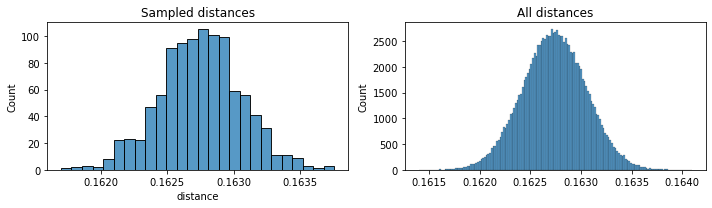

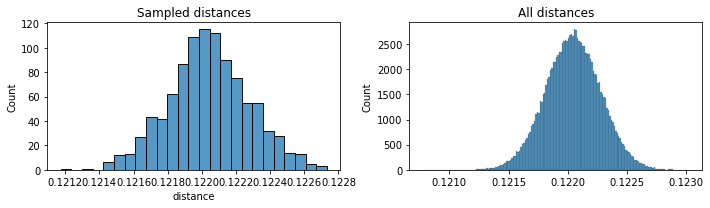

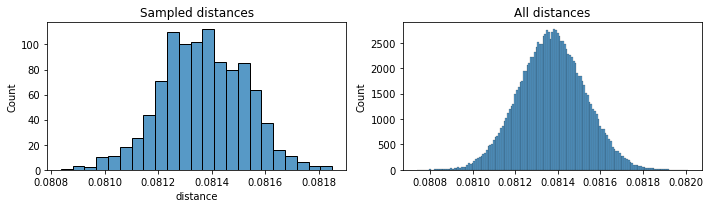

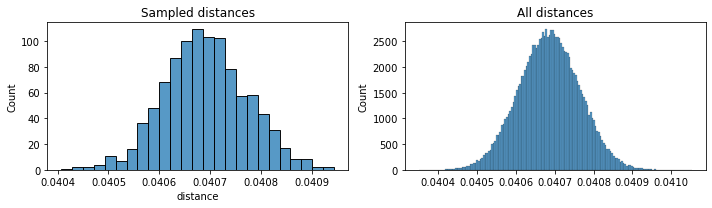

In [149]:
for idx, nl in enumerate(distance_df.noise_level1.unique()):
    f, ax = plt.subplots(ncols=2, figsize=(10,3))
    sns.histplot(data=sampled_df[sampled_df['noise_level1']==nl], x='distance', ax=ax[0])
    ax[0].set_title('Sampled distances')
    sns.histplot([r[-1] for r in resdict[nl]], ax=ax[1])
    ax[1].set_title('All distances')
    plt.tight_layout()
    plt.show()

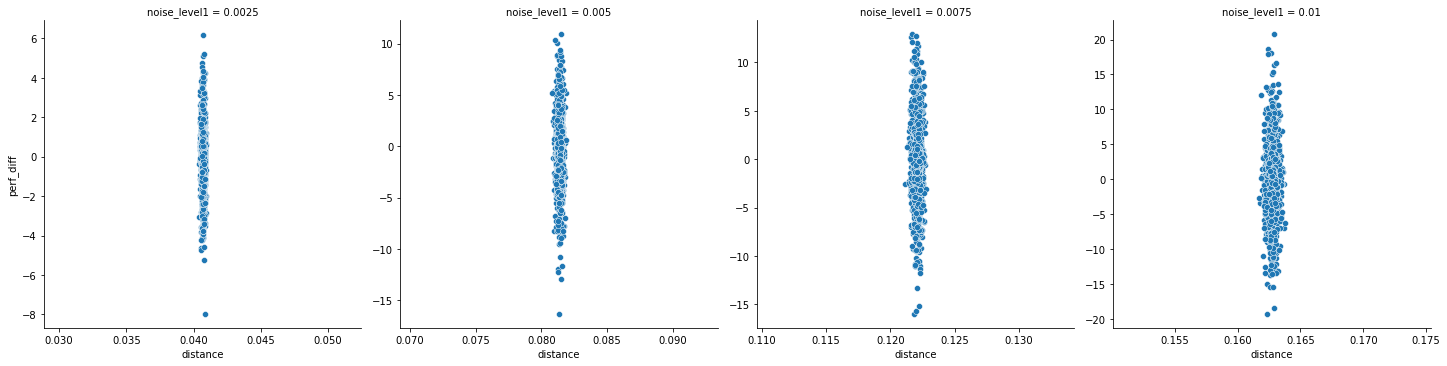

In [153]:
sns.relplot(data=sampled_df, 
            x='distance', y='perf_diff', 
            col='noise_level1',
            facet_kws={'sharex': False, 
                       'sharey': False})
#plt.xlim(0.006, 0.008)
plt.show()

In [154]:
sampled_df.drop(['perf1', 'perf2', 
                 'perf_diff'], axis=1).to_csv('animal_game/models/21_06_10/sampled_pairs.tsv',
                                              sep='\t')

In [ ]:
# More probabilities
# More noise levels